In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import optimize, signal, integrate

from scifit.solvers import FitSolver1D

from sklearn import metrics
from sklearn.linear_model import LinearRegression

Checks:

 - https://www.wolframalpha.com/input?i=solve+%7Bc1+%3D+1%2F%28k1*V%29*%281-k2%29%3B+c2+%3D+-+1%2F%28k1*V%29*k2*n0%7D+for+%7Bk1%2C+k2%7D
 - https://www.wolframalpha.com/input?i=integral+b*x%2F%28a*%28n0-x%29%29


In [2]:
np.random.seed(12345)

In [3]:
rho = 785             # kg/m³ or g/L
M = 60.1              # g/mol
A0 = rho/M            # mol/L

In [4]:
A0

13.061564059900165

In [5]:
k = 8.765e-6
b = 8.901e5
a = 1.234e4

In [6]:
b/a

72.13128038897894

In [7]:
def model(x, k, a, b, A0=A0):
    return k*(a*(A0 - x))/(1 + a*(A0 - x) + b*x)

In [8]:
def ode(t, x, k, a, b, A0):
    return np.array([
        model(x, k, a, b, A0)
    ])

In [9]:
t = np.linspace(0, 10000, 50)

In [10]:
sol = integrate.solve_ivp(ode, [t.min(), t.max()], y0=[0], args=(k, a, b, A0), t_eval=t)

In [11]:
sol

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  2.041e+02 ...  9.796e+03  1.000e+04]
        y: [[ 0.000e+00  1.780e-03 ...  7.164e-02  7.291e-02]]
      sol: None
 t_events: None
 y_events: None
     nfev: 56
     njev: 0
      nlu: 0

In [12]:
xi = sol.y[0,:]

In [13]:
r = ode(t, xi, k, a, b, A0).squeeze()

In [14]:
tn = (t + 5*np.random.normal(size=t.size)).round(1)

In [15]:
data = pd.DataFrame({"t": t, "tn": tn, "xi": xi, "r": r})

In [16]:
data["rinv"] = 1/data["r"]
data["x1"] = data["xi"]/(A0 - data["xi"])
data["x2"] = np.log((A0 - data["xi"])/A0)

In [17]:
data["dxidt"] = data["xi"].diff()/data["tn"].diff()

In [18]:
coefs = np.polyfit(data["tn"], xi, 3)
data["xiP3"] = np.polyval(coefs, data["tn"])
data["rP3"] = np.polyval(np.polyder(coefs, m=1), data["tn"])

In [19]:
data["xiSG"] = signal.savgol_filter(data["xi"], 7, 3)
data["rSG"] = signal.savgol_filter(data["xi"], 7, 3, deriv=1, delta=np.diff(t)[0])

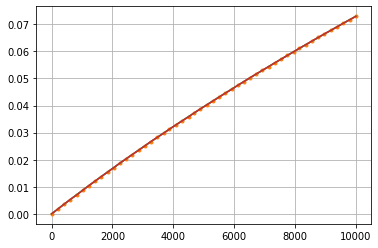

In [20]:
fig, axe = plt.subplots()
axe.plot(data["t"], data["xi"])
axe.plot(data["tn"], data["xi"], linestyle="None", marker=".")
axe.plot(data["tn"], data["xiP3"])
axe.plot(data["tn"], data["xiSG"])
axe.grid()

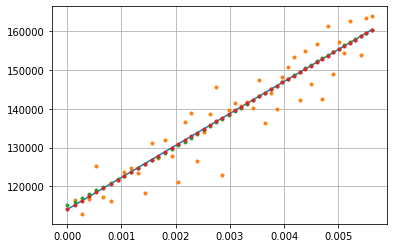

In [21]:
fig, axe = plt.subplots()
axe.plot(data["x1"], data["rinv"])
axe.plot(data["x1"], 1/data["dxidt"], linestyle="None", marker=".")
axe.plot(data["x1"], 1/data["rP3"], linestyle="None", marker=".")
axe.plot(data["x1"], 1/data["rSG"], linestyle="None", marker=".")
axe.grid()

In [22]:
regressor = LinearRegression(fit_intercept=False)

In [23]:
q = data["t"] <= 10000
regressor.fit(data.loc[q, ["xi", "x2"]].values, data.loc[q, "tn"].values)

LinearRegression(fit_intercept=False)

In [24]:
c1, c2 = regressor.coef_
c1, c2

(-8089238.7458880665, -107148748.27071354)

In [25]:
s = regressor.score(data[["xi", "x2"]].values, data["tn"])

In [26]:
k1 = A0/((A0*c1 - c2))
k2 = -c2/(A0*c1 - c2)

In [27]:
k1, k2

(8.762397273592697e-06, 71.88112353241)

In [28]:
OLS = {"k1": k1, "k2": k2, "R2": s, "name": "OLS"}

In [29]:
def naive(x, k1, k2):
    return (1/k1) * ((1 - k2)*x - k2*A0*np.log((A0 - x)/A0)) 

In [30]:
popt, pcov = optimize.curve_fit(naive, data["xi"].values, data["tn"].values)

In [31]:
s2 = metrics.r2_score(data["tn"].values, naive(data["xi"].values, *popt))

In [32]:
NLLS = {"k1": popt[0], "k2": popt[1], "R2": s2, "name": "NLLS"}

In [33]:
def LB(X, y, name):
    model = LinearRegression(fit_intercept=True)
    model.fit(X, y)
    s = model.score(X, y)
    c1 = model.intercept_
    c2 = model.coef_[0]
    k1 = 1/c1
    k2 = c2/c1
    return {
        "k1": k1,
        "k2": k2,
        "R2": s,
        "name": name
    }

In [34]:
lb_th = LB(data[["x1"]].values, data["rinv"].values, name="LB Exact")
lb_th

{'k1': 8.764945620040285e-06,
 'k2': 72.13083907509849,
 'R2': 1.0,
 'name': 'LB Exact'}

In [35]:
lb_dxi = LB(data.loc[1:,["x1"]].values, (1/data.loc[1:,"dxidt"]).values, name="LB First Diff.")
lb_dxi

{'k1': 8.825497590656547e-06,
 'k2': 73.8978815464832,
 'R2': 0.8773966394692153,
 'name': 'LB First Diff.'}

In [36]:
lb_P3 = LB(data[["x1"]].values, (1/data["rP3"]).values, name="LB Poly 3")
lb_P3

{'k1': 8.752560644806894e-06,
 'k2': 71.6322464062605,
 'R2': 0.9995269376245935,
 'name': 'LB Poly 3'}

In [37]:
lb_SG = LB(data[["x1"]].values, (1/data["rSG"]).values, name="LB SavGol")
lb_SG

{'k1': 8.765600382177916e-06,
 'k2': 72.17001052154967,
 'R2': 0.9999948832757523,
 'name': 'LB SavGol'}

In [38]:
results = pd.DataFrame([OLS, NLLS, lb_th, lb_dxi, lb_P3, lb_SG])
results

,k1,k2,R2,name
0,0.000009,71.881124,0.999997,OLS
1,0.000009,71.881124,0.999997,NLLS
2,0.000009,72.130839,1.000000,LB Exact
3,0.000009,73.897882,0.877397,LB First Diff.
4,0.000009,71.632246,0.999527,LB Poly 3
5,0.000009,72.170011,0.999995,LB SavGol


In [39]:
class Model(FitSolver1D):
    @staticmethod
    def model(x, k1, k2):
        return (1/k1) * ((1 - k2)*x[:,0] - k2*A0*np.log((A0 - x[:,0])/A0)) 

In [40]:
model = Model()
sol = model.fit(data[["xi"]].values, data["tn"].values, sigma=5.)

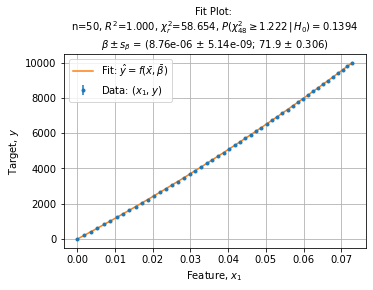

In [41]:
axe = model.plot_fit()

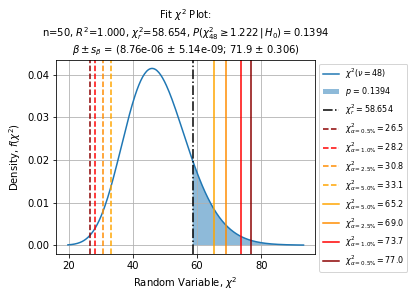

In [42]:
axe = model.plot_chi_square()

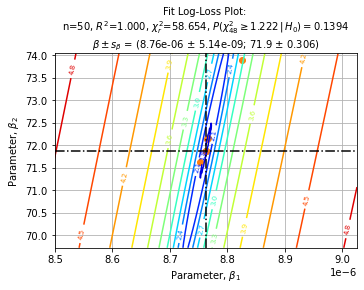

In [48]:
axe = model.plot_loss(factor=0.3, log_loss=True, log_x=False, log_y=False, resolution=200)
axe.scatter(results["k1"], results["k2"])
#axe.grid(which="both")